<a href="https://colab.research.google.com/github/abhishek-1406/SafeScanTool/blob/main/Models/FINAL_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical

Reading the dataset and mapping the labels into numerical figures and doing some mild cleaning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/updated_hatexplain_data.csv')

label_mapping = {'normal': 0, 'offensive': 1, 'hatespeech': 2}
df['label'] = df['majority_label'].map(label_mapping)
print("Label Distribution:\n", df['label'].value_counts())

def mild_clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['cleaned_text'] = df['cleaned_text'].apply(mild_clean_text)

Label Distribution:
 label
1    24670
0    12896
2     7365
Name: count, dtype: int64


TOKENIZATION AND PADDING

In [ ]:
texts = df['cleaned_text'].astype(str).tolist()
labels = df['label'].astype(int).tolist()

max_vocab = 10000
max_length = 50

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

labels_cat = to_categorical(labels, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(
    padded, labels_cat, test_size=0.2, random_state=42, stratify=labels
)

Downloading GloVe package

In [ ]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

Applying word embedding

In [ ]:
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs
print(f'Loaded {len(embeddings_index)} word vectors.')

word_index = tokenizer.word_index
num_words = min(max_vocab, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Building Bi-LSTM Model

In [ ]:
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),  # BiLSTM 1
    Dropout(0.3),
    Bidirectional(LSTM(32)),  # BiLSTM 2
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Handling class imbalance

In [ ]:
y_train_single = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_single), y=y_train_single)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Model training

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights_dict
)

Epoch 1/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.8742 - loss: 0.2557 - val_accuracy: 0.7516 - val_loss: 0.8824
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8756 - loss: 0.2485 - val_accuracy: 0.7491 - val_loss: 0.9055
Epoch 3/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8781 - loss: 0.2512 - val_accuracy: 0.7445 - val_loss: 0.8839
Epoch 4/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8870 - loss: 0.2293 - val_accuracy: 0.7417 - val_loss: 0.9860
Epoch 5/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8861 - loss: 0.2233 - val_accuracy: 0.7175 - val_loss: 0.9723
Epoch 6/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8927 - loss: 0.2115 - val_accuracy: 0.7507 - val_loss: 1.0140
Epoch 7/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8951 - loss: 0.2117 - val_accuracy: 0.7505 - val_loss: 1.0707
Epoch 8/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.9039 - loss: 0.1986 - 

Evaluation and Results

281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

Classification Report:
               precision    recall  f1-score   support

      Normal       0.68      0.70      0.69      2579
   Offensive       0.83      0.80      0.82      4935
  HateSpeech       0.59      0.61      0.60      1473

    accuracy                           0.74      8987
   macro avg       0.70      0.71      0.70      8987
weighted avg       0.75      0.74      0.75      8987

Confusion Matrix:
 [[1812  521  246]
 [ 592 3972  371]
 [ 254  317  902]]


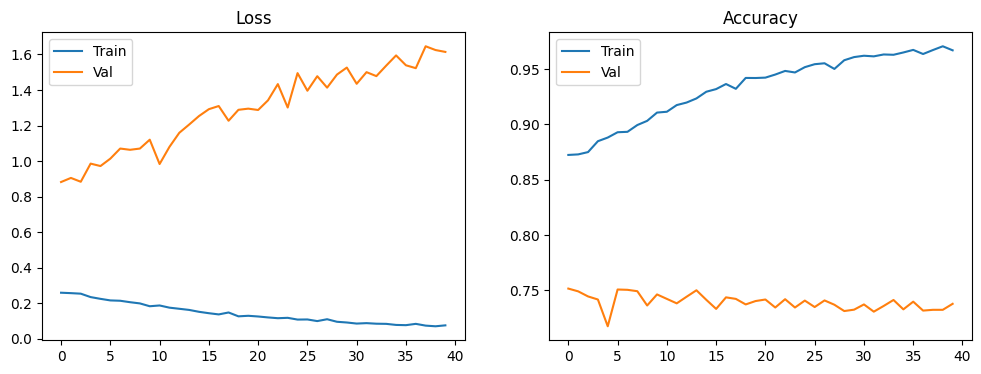

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(
    y_true, y_pred, target_names=["Normal", "Offensive", "HateSpeech"]))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

Save model and tokenizer

In [ ]:
model.save("bilstm_hatexplain_3class.h5")
import joblib
joblib.dump(tokenizer, "tokenizer.pkl")

Loading model and testing with input comments

In [ ]:
label_reverse = {0: "Normal", 1: "Offensive", 2: "HateSpeech"}

def predict_hate_bilstm(text, model, tokenizer, max_length=50):
    text_cleaned = mild_clean_text(text)
    seq = tokenizer.texts_to_sequences([text_cleaned])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    pred = model.predict(padded)
    label_idx = np.argmax(pred)
    print(f"Text: {text}\nPrediction: {label_reverse[label_idx]} (Scores: {pred[0]})\n")

test_comments = [
"Thats fucking cool"

]

for comment in test_comments:
    predict_hate_bilstm(comment, model, tokenizer, max_length)

FLASK API WITH SHAP

In [ ]:
!pip install flask-ngrok

In [ ]:
from flask_ngrok import run_with_ngrok

run_with_ngrok(app)
app.run()

In [ ]:
from flask import Flask, request, jsonify
import joblib
from flask_cors import CORS
import re
import numpy as np
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ================================
# 1. Load Model & Tokenizer
# ================================
model = tf.keras.models.load_model("bilstm_hatexplain_3class.h5")
tokenizer = joblib.load("tokenizer.pkl")

label_reverse = {0: "Normal", 1: "Offensive", 2: "HateSpeech"}
max_length = 50  # must match training

# ================================
# 2. Text Preprocessing
# ================================
def mild_clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def predict_hate_bilstm(text):
    text_cleaned = mild_clean_text(text)
    seq = tokenizer.texts_to_sequences([text_cleaned])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    pred = model.predict(padded)
    label_idx = np.argmax(pred)
    return label_reverse[label_idx], pred[0].tolist(), seq, padded

# ================================
# 3. SHAP Explainability (GradientExplainer Per Token)
# ================================
def explain_text_with_shap(text):
    prediction, scores, seq, padded = predict_hate_bilstm(text)

    # ✅ GradientExplainer directly on full model
    background = np.zeros((1, max_length), dtype=np.int32)
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(padded)

    predicted_class = np.argmax(scores)

    # ✅ Map token IDs to words
    index_word = {v: k for k, v in tokenizer.word_index.items()}
    tokens = [index_word.get(idx, "") for idx in seq[0] if idx != 0]

    # ✅ SHAP returns importance per timestep → take only valid tokens
    # shap_values[predicted_class][0] shape = (max_length,)
    token_shap_values = shap_values[predicted_class][0][:len(tokens)]

    # ✅ Sort top tokens
    top_tokens = sorted(
        zip(tokens, token_shap_values),
        key=lambda x: abs(x[1]),
        reverse=True
    )[:10]

    return prediction, scores, [{"word": w, "shap_value": round(float(v), 4)} for w, v in top_tokens]

# ================================
# 4. Flask App
# ================================
app = Flask(__name__)
CORS(app)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    text = data['text']
    prediction, scores, top_features = explain_text_with_shap(text)
    return jsonify({
        'text': text,
        'prediction': prediction,
        'scores': scores,
        'top_features': top_features
    })

if __name__ == '__main__':
    print("🚀 Server is running on http://127.0.0.1:5003")
    app.run(debug=True, port=5003)
